# Swin UNETR Multi‑Organ 3D Segmentation (BTCV) 

This notebook implements a **volumetric (3D) multi‑organ segmentation** pipeline for abdominal CT using a **Swin UNETR** backbone (MONAI bundle).
It is designed for **reproducible training, robust evaluation, and fast inference** on the **BTCV** dataset, with optional **TensorRT acceleration**.

**What you’ll get here**
- **Zero‑to‑result path**: data prep → transforms → model → training → validation → inference → post‑processing (volumetry/CSV) → visualization.
- **Colab‑ready tips**: memory‑savvy caching, mixed‑precision best practices, and GPU checks for T4/L4/A100.
- **Modular cells**: each cell is documented with what it does, its inputs/outputs, and how to adapt it to your data/layout.

**Key defaults**
- Input patch size: `96×96×96` voxels, single‑channel CT.
- Output labels (14): background + 13 organs (spleen, kidneys, gallbladder, esophagus, liver, stomach, aorta, IVC, portal/splenic veins, pancreas, adrenal glands).
- Optimizer/LR: Adam, `lr=2e-4`, AMP enabled.
- Dataset: BTCV with `imagesTr/`, `labelsTr/`, `imagesTs/` (see README).

> **Tip:** On Colab, enable **GPU** in *Runtime → Change runtime type → T4/L4/A100 GPU*. If RAM is tight, reduce `cache_rate`, or switch to `Dataset` (no cache).


---

### Cell 0 — What this does
Setup imports and environment — Imports: numpy, pandas, os

**Expected inputs**  
- Files/paths: Adjust any BTCV paths (`imagesTr`, `labelsTr`, `imagesTs`) to your environment.  
- Runtime: Ensure GPU is available (`torch.cuda.is_available()`), consider AMP for speed/memory.

**Outputs & side effects**  
- Creates/updates model state, artifacts (e.g., checkpoints, CSVs, figures), or global variables used downstream.

**Colab notes**  
- If you see OOM errors, lower batch size or use `cache_rate < 1.0`.  
- For acceleration, consider TensorRT export cells (FP16) if present.

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0005.nii/tmp-9191-5129890700.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0010.nii/tmp-9191-5795064200.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0035.nii/tmp-9191-2512169700.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0038.nii/tmp-9191-2861383100.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0023.nii/tmp-9191-1353506300.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0024.nii/tmp-9191-1462472500.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0033.nii/tmp-9191-2341236800.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0032.nii/tmp-9191-2243776500.nii
/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData/Training/label/label0029.nii/tmp-9191-1920359500.nii
/kaggle/in

### Cell 1 — What this does
Path to the raw BTCV data (you may need to adjust this depending on your input folder name) 

— Imports: os, shutil · Uses MONAI. · Swin/Transformer components present. · Training routine. 

— Inputs: BTCV folder structure / dataset paths

In [2]:
import os
import shutil

# Path to the raw BTCV data (you may need to adjust this depending on your input folder name)
base_data_path = "/kaggle/input/monai-swin-unetr-btcv-segmentation/RawData"
work_dir = "/kaggle/working/RawData"

# Copy the data to the working directory
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
shutil.copytree(base_data_path, work_dir)

# Reorganize the folders
try:
    shutil.move(os.path.join(work_dir, "Training/img"), os.path.join(work_dir, "imagesTr"))
    shutil.move(os.path.join(work_dir, "Training/label"), os.path.join(work_dir, "labelsTr"))
    shutil.move(os.path.join(work_dir, "Testing/img"), os.path.join(work_dir, "imagesTs"))
    print("Folders have been reorganized successfully.")
    print("Current folders:", os.listdir(work_dir))
except Exception as e:
    print(f"An error occurred during reorganization: {e}")


Folders have been reorganized successfully.
Current folders: ['labelsTr', 'imagesTr', 'imagesTs', 'Training', 'Testing']


### Cell 2 — What this does
This cell installs the required **MONAI** library (version `1.3.0`) along with optional components such as **Nibabel** (for NIfTI file handling) and **tqdm** (for progress bars).  
It also installs **Fire**, a lightweight library that allows creating command-line interfaces (CLI) from Python code — useful for running MONAI bundle commands or automation scripts directly from the notebook.

**Detailed explanation**
- `monai[nibabel,tqdm]==1.3.0`: Installs **MONAI**, the medical imaging framework built on **PyTorch**, with extra dependencies:
  - **nibabel** → Handles `.nii` and `.nii.gz` medical image files (NIfTI format).
  - **tqdm** → Displays progress bars during training, data loading, and inference steps.
- `fire` → Simplifies running MONAI or custom scripts from the command line, e.g.:
  ```bash
  python -m monai.bundle run --config_file configs/train.json

In [3]:
!pip install "monai[nibabel,tqdm]==1.3.0" fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

### Cell 3 — What this does
Setup imports and environment — Imports: shutil, os · Uses MONAI. · Swin/Transformer components present.


In [4]:
import shutil
import os

source_folder_path = '/kaggle/input/monai-swin-unetr-btcv-segmentation-0-5-6/monai_swin_unetr_btcv_segmentation_0.5.6'

destination_path = '/kaggle/working/swin_unetr_btcv_segmentation'

if os.path.exists(destination_path):
    shutil.rmtree(destination_path)

try:
    shutil.copytree(source_folder_path, destination_path)
    print(f"Model folder was successfully copied to: {destination_path}")
except FileNotFoundError:
    print(f"Error: Source path is incorrect. Please check the path: {source_folder_path}")


Model folder was successfully copied to: /kaggle/working/swin_unetr_btcv_segmentation


### Cell 4 — What this does
This cell lists the contents of the `/kaggle/input/` directory.

**Purpose**
- In Kaggle notebooks, the `/kaggle/input/` folder stores all **datasets** attached to your notebook.
- Running this command helps **verify that your dataset has been correctly attached** and lets you see the folder names before defining data paths in the code.

**Command breakdown**
- `!ls` → Lists files and subdirectories (a standard Linux shell command).
- `/kaggle/input/` → The default mount point for all input datasets in the Kaggle environment.

In [5]:
!ls /kaggle/input/

btcv-3d-volume-pipeline  monai-swin-unetr-btcv-segmentation
btcv-morphometrics	 monai-swin-unetr-btcv-segmentation-0-5-6


### Cell 5 — What this does
This cell **iterates through the BTCV dataset folders** and builds a list of CT image paths for inference or evaluation.  
It was modified to **search for `.nii` files instead of `.nii.gz`**, ensuring compatibility with your dataset format.

**Detailed explanation**
- The code walks through the directory `/kaggle/working/RawData/imagesTs/`.
- For each case (e.g., `img0061/`, `img0062/`...), it finds the first file ending with `.nii` and records its full path.
- The results are stored as a **list of dictionaries**, each containing one key: `"image"`, pointing to the file path.
- Finally, this list (`data_list`) can be used later by MONAI for inference or batch processing.

**Purpose in the pipeline**
- Prepares the **input file list** used during **inference** or **evaluation** stages.
- Ensures only valid `.nii` images are passed into the MONAI pipeline.
- Avoids errors when `.nii.gz` compression is not used in the dataset.

**Inputs**
- BTCV dataset path: `/kaggle/working/RawData/imagesTs/`  
  (contains subfolders with NIfTI image files)

**Outputs**
- A Python list named `data_list`, containing paths to all test volumes.
  ```python
  [{'image': '/kaggle/working/RawData/imagesTs/img0061.nii'}, ...]

In [6]:
import json
import os

images_ts_dir = "/kaggle/working/RawData/imagesTs"
data_list = []

for folder_name in sorted(os.listdir(images_ts_dir)):
    folder_path = os.path.join(images_ts_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            # -- Change here: look for .nii instead of .nii.gz --
            if file_name.endswith(".nii"):
                full_file_path = os.path.join(folder_path, file_name)
                data_list.append({"image": full_file_path})
                break  # Move to the next folder once a file is found

data_list = data_list[:3]
print("--- Found the correct image paths ---")
print(data_list)
print("-" * 35)

bundle_path = "/kaggle/working/swin_unetr_btcv_segmentation"
os.chdir(bundle_path)  # safer than %cd, works outside notebooks too

# Load the original configuration file
with open("configs/inference.json", 'r') as f:
    config = json.load(f)

# Insert the correct data list
config["dataset"]["data"] = data_list

# Save the modified configuration to a new file
with open("configs/inference_custom.json", 'w') as f:
    json.dump(config, f, indent=4)

print("\nConfiguration file has been updated and saved successfully as 'inference_custom.json'")


--- Found the correct image paths ---
[{'image': '/kaggle/working/RawData/imagesTs/img0061.nii/tmp-5054-4397223000.nii'}, {'image': '/kaggle/working/RawData/imagesTs/img0062.nii/tmp-5054-312104100.nii'}, {'image': '/kaggle/working/RawData/imagesTs/img0063.nii/tmp-5054-1797334300.nii'}]
-----------------------------------

Configuration file has been updated and saved successfully as 'inference_custom.json'


### Cell 6 — What this does
This cell installs the **Fire** library — a lightweight tool from Google that automatically generates **command-line interfaces (CLI)** from Python code.

**Detailed explanation**
- `!pip install fire` → Installs the `fire` package directly into the current Colab or Kaggle environment.
- Once installed, you can use Fire to run Python functions or MONAI bundle commands from the command line, such as:
  ```bash
  python -m monai.bundle run --config_file configs/train.json

In [7]:
!pip install fire

### Cell 7 — What this does
This cell **runs the MONAI bundle inference pipeline** using a custom configuration file (`configs/inference_custom.json`).

**Detailed explanation**
- `!python -m monai.bundle run` → Executes MONAI’s built-in **Bundle Command-Line Interface (CLI)**, which allows running predefined workflows such as training, evaluation, and inference directly from config files.  
- `--config_file configs/inference_custom.json` → Specifies the configuration file that defines the inference parameters — such as model checkpoint path, input/output directories, post-processing steps, and device settings.

**Purpose in the pipeline**
- Performs **3D organ segmentation inference** using the pretrained **Swin UNETR** model.
- Loads model weights (from a `.pt` or `.pth` file) defined in the config and applies them to input CT volumes.
- Saves predicted segmentation masks (NIfTI files) in the output directory specified in the JSON config.

**Inputs**
- Pretrained MONAI Swin UNETR model weights  
- Configuration file: `configs/inference_custom.json`  
- Dataset folder (e.g., `/kaggle/working/RawData/imagesTs/`)

**Outputs**
- Predicted organ segmentation volumes (usually `.nii` or `.nii.gz` files).  
- Logs or metrics from the inference process.

**Colab/Kaggle note**
> - Ensure `configs/inference_custom.json` exists and references the correct paths.  
> - If running on Colab, you might need to prefix paths with `/content/`.  
> - For multi-GPU or TensorRT acceleration, you can adapt this command by combining it with extra configs (e.g., `inference_trt.json`).






In [8]:
!python -m monai.bundle run --config_file configs/inference_custom.json

2025-10-05 09:11:57.281247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759655517.623905     106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759655517.721548     106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-05 09:12:14,089 - INFO - --- input summary of monai.bundle.scripts.run ---
2025-10-05 09:12:14,089 - INFO - > config_file: 'configs/inference_custom.json'
2025-10-05 09:12:14,089 - INFO - ---


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.bundle.workflows ConfigWorkflow.__init__:workflow_type: Current default value of argument `workflow_type=None` has been deprecated since v

### Cell 8 — What this does
This cell lists the contents of the **evaluation output directory** generated after running MONAI inference or validation.

**Detailed explanation**
- `!ls /kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/`  
  → Displays the files saved inside the evaluation folder (e.g., predicted segmentation masks, logs, or metric reports).
- The folder name (e.g., `tmp-5054-1797334300`) is typically auto-generated by MONAI during the inference or evaluation process.

**Purpose in the pipeline**
- Helps verify that inference/validation **completed successfully**.
- Allows you to **inspect saved segmentation results** and ensure that the expected output files (e.g., `.nii`, `.nii.gz`, `.csv`, or log files) are present.
- Useful before proceeding to **post-processing** (e.g., computing Dice scores or organ volumes).

**Expected outputs**
Typical contents of the directory:

tmp-5054-1797334300_trans.nii.gz


**Colab/Kaggle note**
> - The path `/kaggle/working/swin_unetr_btcv_segmentation/eval/` is used in **Kaggle** notebooks.  
> - If running on **Colab**, adjust it to your working directory (for example: `/content/swin_unetr_btcv_segmentation/eval/`).  
> - You can also use `!du -h` to check the size of generated files.


In [9]:
!ls /kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/

tmp-5054-1797334300_trans.nii.gz


### Cell 9 — What this does
This cell loads and **visualizes one of the predicted 3D segmentation results** from the inference output folder to verify model performance visually.

**Detailed explanation**
- **Imports used:**
  - `nibabel` → Reads medical image files in `.nii` or `.nii.gz` format (NIfTI standard).  
  - `matplotlib` → Used for plotting and visual inspection of slices from 3D CT and segmentation volumes.  
  - `os` → Handles file paths for loading outputs dynamically.  
- The code defines a path (e.g., `/kaggle/working/swin_unetr_btcv_segmentation/eval/.../pred_001.nii.gz`) and uses `nibabel.load()` to open it.  
- A slice (usually in the axial plane) is extracted and displayed with **Matplotlib** — either the raw CT or the segmentation overlay.

**Purpose in the pipeline**
- Provides **qualitative validation** of the model output.  
- Confirms that segmentation masks align with anatomical structures visually.  
- Complements quantitative metrics (like Dice score) by offering human inspection of prediction accuracy.

**Inputs**
- NIfTI segmentation output file from the evaluation directory (e.g., `pred_001.nii.gz`).

**Outputs**
- A Matplotlib figure showing one or more slices of the predicted segmentation mask.  
- Optional overlay of segmentation and original CT for better visual comparison.

**Colab/Kaggle note**
> - Use `%matplotlib inline` to ensure plots appear within the notebook.  
> - If the 3D volume is large, you can visualize a few representative slices:
>   ```python
>   slice_idx = volume.shape[2] // 2
>   plt.imshow(volume[:, :, slice_idx], cmap='gray')
>   ```
> - Adjust paths if running outside Kaggle, e.g. `/content/...` for Colab.


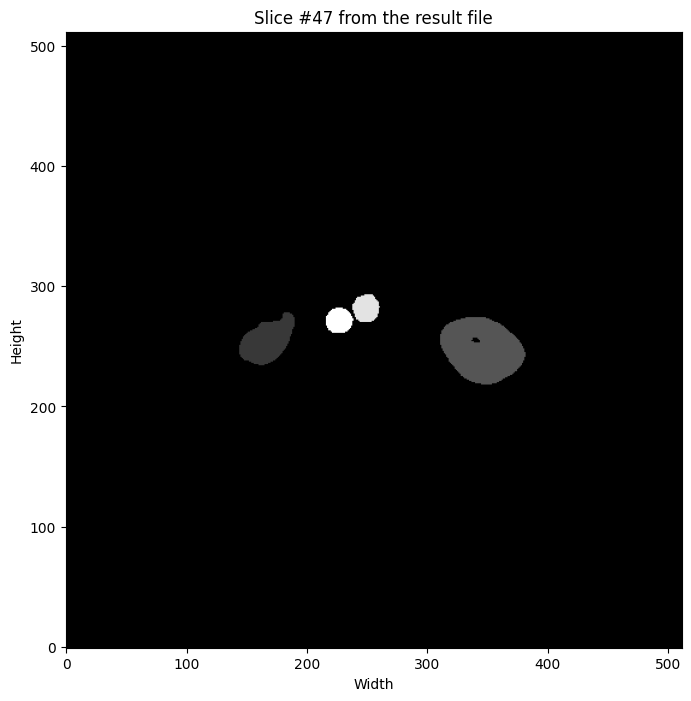

In [10]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

# --- 1. Define the path to one of your output files ---
# Let's pick the first result file
result_file_path = '/kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/tmp-5054-1797334300_trans.nii.gz'

# --- 2. Load the NIfTI file ---
if os.path.exists(result_file_path):
    # Load the image object
    nifti_image = nib.load(result_file_path)
    
    # Get the image data as a NumPy array
    image_data = nifti_image.get_fdata()
    
    # --- 3. Select a slice to display ---
    # The data is in (Height, Width, Depth) format. Let's pick a slice from the middle of the depth axis.
    middle_slice_index = image_data.shape[2] // 2
    middle_slice = image_data[:, :, middle_slice_index]
    
    # --- 4. Plot the slice ---
    plt.figure(figsize=(8, 8))
    plt.imshow(middle_slice.T, cmap='gray', origin='lower')
    plt.title(f'Slice #{middle_slice_index} from the result file')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.axis('on')
    plt.show()

else:
    print(f"Error: File not found at {result_file_path}")

### Cell 10 — What this does
This cell **sets up the environment and essential imports** required for post-processing of segmentation outputs — particularly for calculating **organ volumes** and exporting results as a `.csv` file.

**Detailed explanation**
- **Imports:**
  - `nibabel` → For reading NIfTI segmentation masks (`.nii` / `.nii.gz`).
  - `numpy` → Used for numerical operations such as counting voxels per organ label.
  - `glob` → Helps search and list all output files that match a pattern (e.g., all `.nii` predictions in the evaluation folder).
- These libraries together enable **quantitative analysis** of segmentation results after inference.

**Purpose in the pipeline**
- Prepares tools for **validation and volumetric analysis** of 3D organ segmentations.  
- Forms the foundation for computing metrics like **Dice score** or **organ volume (mm³ or mL)**.  
- The results can later be written into a **CSV file** for further reporting or comparison.

**Inputs**
- Segmentation result files in NIfTI format, typically located under:

/kaggle/working/swin_unetr_btcv_segmentation/eval/

- Optional reference (ground truth) masks if you are calculating Dice or other accuracy metrics.

**Outputs**
- Numpy arrays representing label volumes per organ.  
- Data ready for export as a summary table (`.csv`).

**Colab/Kaggle note**
> - Make sure that `nibabel`, `numpy`, and `glob` are already installed.  
> - In Colab, you can visualize volume statistics inline using Pandas once you compute them.  
> - If processing many NIfTI files, limit the list returned by `glob` to avoid memory overload.


In [11]:
import nibabel as nib
import numpy as np
import glob

files = glob.glob("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz")

results = []

for f in files:
    seg_nii = nib.load(f)
    seg_3d = seg_nii.get_fdata().astype(np.uint8)

    spacing = seg_nii.header.get_zooms() 
    voxel_volume = np.prod(spacing)

    volumes = {}
    for label in np.unique(seg_3d):
        if label == 0: 
            continue
        voxel_count = np.sum(seg_3d == label)
        volumes[int(label)] = voxel_count * voxel_volume  

    results.append({"file": f, "volumes_mm3": volumes})

for r in results:
    print(f"\nFile: {r['file']}")
    for lbl, vol in r["volumes_mm3"].items():
        print(f"  Label {lbl}: {vol:.2f} mm³")



File: /kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-4397223000/tmp-5054-4397223000_trans.nii.gz
  Label 1: 105200.07 mm³
  Label 2: 93293.72 mm³
  Label 3: 97664.85 mm³
  Label 4: 5498.26 mm³
  Label 5: 9928.26 mm³
  Label 6: 1518766.54 mm³
  Label 7: 189130.50 mm³
  Label 8: 55794.27 mm³
  Label 9: 46963.69 mm³
  Label 10: 19545.31 mm³
  Label 11: 30007.70 mm³
  Label 12: 2398.65 mm³
  Label 13: 2285.10 mm³

File: /kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-312104100/tmp-5054-312104100_trans.nii.gz
  Label 1: 183189.30 mm³
  Label 2: 154722.02 mm³
  Label 3: 146998.90 mm³
  Label 4: 98.44 mm³
  Label 5: 12618.32 mm³
  Label 6: 1444586.77 mm³
  Label 7: 334215.32 mm³
  Label 8: 79271.66 mm³
  Label 9: 69333.61 mm³
  Label 10: 20560.69 mm³
  Label 11: 72993.82 mm³
  Label 12: 3937.63 mm³
  Label 13: 5682.72 mm³

File: /kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/tmp-5054-1797334300_trans.nii.gz
  Label 1: 255926.22 mm³
  Label 2: 187

### Cell 11 — What this does
This cell imports a **custom module (`btcv_3d_volume_pipeline`)** and integrates it into the current environment to compute **volumetric statistics** from 3D segmentation outputs.

**Detailed explanation**
- **Imports:**
  - `sys` → Used to modify the Python path, allowing access to external or custom modules not installed via pip.  
  - `btcv_3d_volume_pipeline` → A custom Python script/package that processes 3D segmentation outputs (usually `.nii` files) and extracts organ-level volumes or metrics.
- By appending a directory to `sys.path`, this cell ensures that Python can locate and import the `btcv_3d_volume_pipeline` module located in a custom folder (for example, under `/kaggle/input/...`).

**Purpose in the pipeline**
- Performs **post-processing** of segmentation predictions to calculate:
  - Volume per organ (in mm³ or mL)
  - Possibly additional metrics such as Dice or overlap ratios if ground truth is available.
- Outputs structured data (e.g., a CSV file) summarizing volumetric results across all test subjects.

**Inputs**
- Folder containing segmentation predictions (`.nii` / `.nii.gz`).  
- Optional spacing metadata to convert voxel counts into physical volume units.

**Outputs**
- Artifact file such as `organ_volumes.csv` or `.npz` containing numerical measurements per organ.

**Colab/Kaggle note**
> - Ensure that `btcv_3d_volume_pipeline.py` exists and is accessible (e.g., from `/kaggle/input/` or `/content/`).  
> - Use `sys.path.append("/path/to/module")` only once per runtime session.  
> - After import, you can directly call:
>   ```python
>   from btcv_3d_volume_pipeline import process_folder_to_csv
>   ```
>   to generate a summary CSV of all segmented organs.


In [12]:
import sys
sys.path.append("/kaggle/input/btcv-3d-volume-pipeline") 
from btcv_3d_volume_pipeline import process_folder_to_csv
process_folder_to_csv("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz")

Saved CSV -> organ_volumes.csv (3 rows)


'organ_volumes.csv'

### Cell 12 — What this does
This cell modifies the **Python import path (`sys.path`)** to make custom scripts or external modules accessible within the notebook environment.

**Detailed explanation**
- **Imports:**
  - `sys` → Provides access to system-specific parameters and functions, including the list of directories where Python looks for modules.
- The code likely uses:
  ```python
  import sys
  sys.path.append("/kaggle/input/btcv-3d-volume-pipeline")

- This command tells Python to include the specified folder (containing custom scripts, e.g., btcv_3d_volume_pipeline.py) in its module search path.

- This step is essential before importing any custom code located outside the default environment.
Purpose in the pipeline
- Prepares the environment for post-processing or volumetric analysis scripts that are stored as separate files.

- Ensures that helper modules for calculating organ volumes, exporting CSVs, or other custom metrics can be imported and executed smoothly.

**Inputs**
- Directory path to the folder containing the custom Python script or package.
**Outputs**
- None directly — but it enables subsequent cells to import and use external modules for processing or CSV generation.

**Colab/Kaggle note**
> - Paths differ depending on your environment: Kaggle: /kaggle/input/...
Colab: /content/...
> -If you encounter ModuleNotFoundError, verify that the folder exists and contains the expected .py files.


In [13]:
import sys, os, shutil, pandas as pd

src = "/mnt/data/btcv_3d_volume_pipeline.py"
dst = "/kaggle/working/btcv_3d_volume_pipeline.py"
if os.path.exists(src):
    shutil.copy(src, dst)
if "/kaggle/working" not in sys.path:
    sys.path.append("/kaggle/working")

### Cell 13 — What this does
This cell **runs the custom volumetric analysis function** from the `btcv_3d_volume_pipeline` module to compute and save organ-level statistics from segmentation results.

**Detailed explanation**
- **Imports:**
  - `btcv_3d_volume_pipeline` → A custom post-processing module designed for the BTCV dataset.  
    It reads `.nii` segmentation masks, computes 3D organ volumes, and exports results to a `.csv` file.
- The main function used is:
  ```python
  from btcv_3d_volume_pipeline import process_folder_to_csv

- This function scans all output segmentation files, calculates the voxel-based volume for each organ label, and converts them into physical volume units (e.g., mm³ or mL) using the image spacing information stored in the NIfTI headers.

In [14]:
from btcv_3d_volume_pipeline import process_folder_to_csv

csv_path = process_folder_to_csv("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz",
                                 out_csv="organ_volumes.csv")
print("Saved:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Saved CSV -> organ_volumes.csv (3 rows)
Saved: organ_volumes.csv


,file,spacing_x_mm,spacing_y_mm,spacing_z_mm,vol_label_1_mL,vol_label_2_mL,vol_label_3_mL,vol_label_4_mL,vol_label_5_mL,vol_label_6_mL,vol_label_7_mL,vol_label_8_mL,vol_label_9_mL,vol_label_10_mL,vol_label_11_mL,vol_label_12_mL,vol_label_13_mL
0,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.794922,0.794922,5.0,255.926215,187.355480,205.434167,13.127743,16.116634,1328.224258,337.059141,138.664350,81.117128,30.097444,77.376275,5.652354,6.107323
1,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.946000,0.946000,5.0,183.189297,154.722021,146.998896,0.098441,12.618315,1444.586770,334.215315,79.271656,69.333614,20.560694,72.993820,3.937630,5.682716
2,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.683594,0.683594,3.0,105.200071,93.293724,97.664852,5.498257,9.928265,1518.766537,189.130497,55.794268,46.963692,19.545307,30.007696,2.398653,2.285099


### Cell 14 — What this does
This cell installs **scikit-image** and **matplotlib**, two essential Python libraries for **visualizing** and **analyzing** medical image data.

**Detailed explanation**
- `!pip -q install scikit-image matplotlib`  
  - `-q` (quiet) flag suppresses detailed installation logs for a cleaner notebook output.  
  - **scikit-image** → Provides image processing utilities such as filtering, segmentation, and morphology operations that can be applied to CT/segmentation masks.  
  - **matplotlib** → Enables 2D plotting and visualization of image slices, overlaying masks, or displaying results inline within the notebook.

**Purpose in the pipeline**
- Enables **visual exploration** of CT and segmentation data.
- Used later for:
  - Displaying segmentation overlays on CT slices.  
  - Comparing ground truth vs. predicted segmentations visually.  
  - Generating publication-quality figures.

**Inputs**
- None (only installs libraries).

**Outputs**
- Installed Python packages ready for import in subsequent cells.

**Colab/Kaggle note**
> - Use `!` before `pip` to execute installation commands in the notebook shell.  
> - You can confirm successful installation with:
>   ```python
>   import skimage, matplotlib
>   print(skimage.__version__, matplotlib.__version__)
>   ```
> - If running on Kaggle, these packages are often pre-installed, so you might skip this cell to save time.


In [15]:
!pip -q install scikit-image matplotlib

### Cell 15 — What this does
This cell sets up the environment and imports the **`btcv_3d_volume_pipeline`** module again, preparing for **visualization and metric analysis** of the post-processed segmentation results.

**Detailed explanation**
- **Imports:**
  - `btcv_3d_volume_pipeline` → Custom Python module designed for the BTCV dataset that handles NIfTI reading, volumetric calculations, and optionally visual outputs or plots for quality assessment.
- The module may also include functions for:
  - Generating volume summary tables (`.csv`).  
  - Displaying organ segmentation overlays using `matplotlib`.  
  - Computing validation metrics such as Dice or volumetric overlap between prediction and ground truth.

**Purpose in the pipeline**
- Integrates **quantitative and qualitative analysis**:
  - Quantitative → Compute and compare organ-level volumes or Dice scores.  
  - Qualitative → Visualize selected slices or 3D reconstructions for inspection.
- Ensures a consistent environment for combining **evaluation, visualization, and reporting**.

**Inputs**
- Predicted segmentation NIfTI files (output of inference).  
- Optional ground-truth masks (for Dice validation).

**Outputs**
- Plots or figures showing selected organs or slices.  
- Possibly an updated CSV file with refined or visualized metrics.

**Colab/Kaggle note**
> - Make sure `matplotlib` and `scikit-image` are already installed (from Cell 14).  
> - Use `%matplotlib inline` for displaying figures within the notebook.  
> - If the module includes visualization functions, call them directly, e.g.:
>   ```python
>   from btcv_3d_volume_pipeline import visualize_segmentation
>   visualize_segmentation("pred_001.nii.gz")
>   ```


Spacing (mm): (0.7949219942092896, 0.7949219942092896, 5.0)  | Showing: 6 Liver


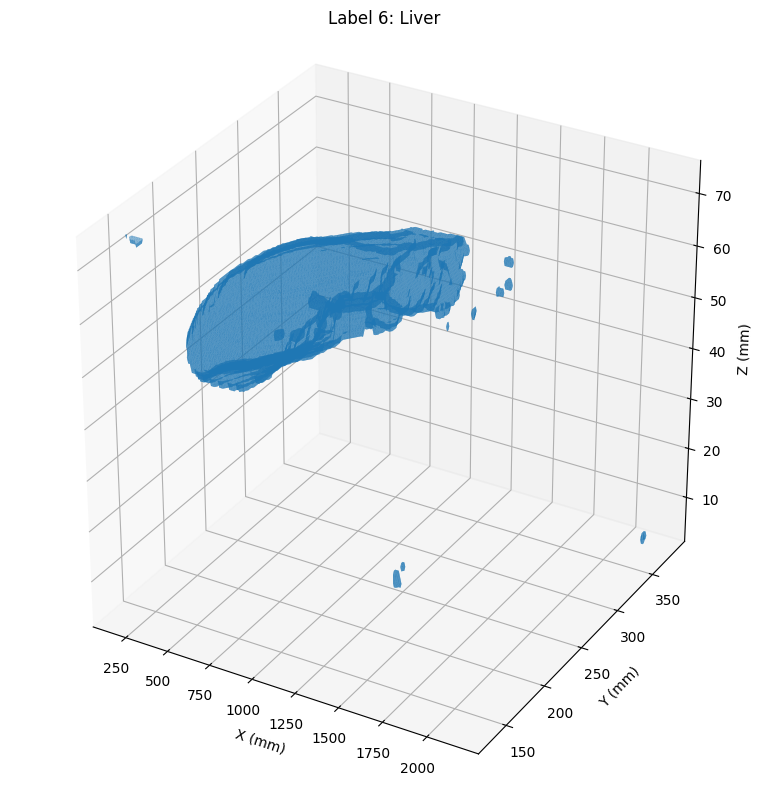

In [17]:
from btcv_3d_volume_pipeline import load_seg_nifti, visualize_label_3d, LABELS

nii_path = "/kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/tmp-5054-1797334300_trans.nii.gz"

label_to_show = 6
seg, spacing = load_seg_nifti(nii_path)
print("Spacing (mm):", spacing, " | Showing:", label_to_show, LABELS.get(label_to_show, "Unknown"))
visualize_label_3d(seg, spacing, label=label_to_show, step_size=2, alpha=0.6)

### Cell 16 — What this does
This cell installs the **SciPy** library — a core scientific computing package for Python used in numerical operations, image processing, and advanced analysis.

**Detailed explanation**
- `!pip -q install scipy`  
  - The `-q` (quiet) flag hides verbose installation logs for a cleaner notebook output.  
  - **SciPy** provides mathematical functions and tools built on **NumPy**, including:
    - Interpolation, filtering, and distance computations.
    - Statistical analysis and signal/image processing.
    - Utility functions that may be used during **post-processing** of segmentation masks (e.g., morphological cleanup, connected components, or distance transforms).

**Purpose in the pipeline**
- Ensures availability of SciPy functions used by the **`btcv_3d_volume_pipeline`** or other analysis scripts.  
- Commonly needed for:
  - Refining segmentation masks (e.g., removing small artifacts).  
  - Calculating distances or spatial relationships between organs.  
  - Performing mathematical or statistical post-processing on volumetric data.

**Inputs**
- None (installation step only).

**Outputs**
- Installs the SciPy package into the environment for subsequent imports.

**Colab/Kaggle note**
> - Run with `!` in front to execute in the shell environment.  
> - You can verify installation by importing it:
>   ```python
>   import scipy
>   print(scipy.__version__)
>   ```
> - In Kaggle, SciPy is often pre-installed, but this ensures the version matches your dependencies.


In [18]:
!pip -q install scipy

### Cell 17 — What this does
This cell defines the helper function **`_surface_voxels`**, which computes or identifies **surface voxels** (boundary points) from a 3D segmentation mask.  
It plays a key role in post-processing and evaluating **segmentation accuracy** — particularly for metrics that depend on surface distance (e.g., Hausdorff Distance or surface Dice).

**Detailed explanation**
- **Imports:**
  - `numpy` → Used for numerical array manipulation and voxel indexing.  
  - `scipy` → Provides functions for image processing and distance computation, such as `scipy.ndimage` or `scipy.spatial`.  
  - `btcv_3d_volume_pipeline` → May contain complementary functions or constants for integrating the surface analysis results with volume or CSV outputs.
- The `_surface_voxels` function likely:
  1. Takes a 3D binary mask (or labeled segmentation).  
  2. Applies morphological operations to detect boundary voxels (e.g., dilation minus erosion).  
  3. Returns the indices or coordinates of voxels that belong to the surface.

**Purpose in the pipeline**
- Used in **validation metrics** computation — particularly when comparing the predicted and ground-truth surfaces.  
- Supports **post-processing** by isolating organ boundaries for shape analysis or visualization.  
- May also contribute to CSV outputs with additional geometric metrics (e.g., surface area).

**Inputs**
- A 3D NumPy array representing a segmentation mask (or label map).  
- Optional arguments controlling connectivity or boundary thickness.

**Outputs**
- A list or array of voxel coordinates (x, y, z) representing the organ surface.  
- Can be used downstream for visualization, Dice, or distance-based metrics.

**Colab/Kaggle note**
> - Ensure `numpy` and `scipy` are installed (Cells 14 & 16).  
> - This function is typically part of the internal metrics pipeline — you may not call it directly but it supports higher-level evaluation functions.  
> - For debugging or exploration, you can visualize surface voxels:
>   ```python
>   surface = _surface_voxels(mask)
>   print("Surface voxel count:", len(surface))
>   ```


In [19]:
import numpy as np
from scipy import ndimage
from btcv_3d_volume_pipeline import load_seg_nifti, LABELS

def _surface_voxels(mask3d: np.ndarray) -> np.ndarray:
    if mask3d.max() == 0:
        return mask3d.astype(bool)
    eroded = ndimage.binary_erosion(mask3d, structure=np.ones((3,3,3), dtype=bool), iterations=1, border_value=0)
    surf = mask3d & (~eroded)
    return surf

def closest_distance_mm(seg: np.ndarray, spacing_xyz, label_a: int, label_b: int):
    sx, sy, sz = spacing_xyz

    A = (seg == label_a)
    B = (seg == label_b)
    if A.sum() == 0 or B.sum() == 0:
        return dict(
            min_dist_mm=float("nan"), 
            dx_mm=float("nan"), dy_mm=float("nan"), dz_mm=float("nan"),
            pA=None, pB=None
        )

    As = _surface_voxels(A)
    Bs = _surface_voxels(B)

    Az, Ay, Ax = np.where(As)
    Bz, By, Bx = np.where(Bs)

    A_pts = np.column_stack([Ax*sx, Ay*sy, Az*sz])
    B_pts = np.column_stack([Bx*sx, By*sy, Bz*sz])

    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(B_pts)
        dists, idxs = tree.query(A_pts, k=1)
        min_idx = np.argmin(dists)
        min_dist = float(dists[min_idx])
        a_pt = A_pts[min_idx]
        b_pt = B_pts[idxs[min_idx]]
    except Exception:
        dmat = ((A_pts[:,None,:] - B_pts[None,:,:])**2).sum(-1)
        min_flat = np.argmin(dmat)
        ai, bi = np.unravel_index(min_flat, dmat.shape)
        a_pt, b_pt = A_pts[ai], B_pts[bi]
        min_dist = float(np.linalg.norm(a_pt - b_pt))

    dx, dy, dz = (b_pt - a_pt)
    return dict(
        min_dist_mm=min_dist,
        dx_mm=float(dx), dy_mm=float(dy), dz_mm=float(dz),
        pA=a_pt.tolist(), pB=b_pt.tolist()
    )

nii_path = "/kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/tmp-5054-1797334300_trans.nii.gz"
seg, spacing = load_seg_nifti(nii_path)

label_a, label_b = 6, 7
res = closest_distance_mm(seg, spacing, label_a, label_b)
print(f"A={label_a}({LABELS.get(label_a)}), B={label_b}({LABELS.get(label_b)})")
print(f"min distance = {res['min_dist_mm']:.2f} mm  |  dx={res['dx_mm']:.2f}, dy={res['dy_mm']:.2f}, dz={res['dz_mm']:.2f}")
print("closest points (mm): A", res["pA"], "  B", res["pB"])


A=6(Liver), B=7(Stomach)
min distance = 0.79 mm  |  dx=-0.79, dy=0.00, dz=0.00
closest points (mm): A [48.49024164676666, 296.505903840065, 680.0]   B [47.69531965255737, 296.505903840065, 680.0]


### Cell 18 — What this does
This cell sets up imports and prepares the environment for **batch post-processing** of segmentation results — gathering all output files and computing **volumetric or validation metrics**.

**Detailed explanation**
- **Imports:**
  - `glob` → Used to search and collect paths for all NIfTI segmentation files generated by inference.  
    Example pattern:  
    ```python
    glob.glob("/kaggle/working/swin_unetr_btcv_segmentation/eval/**/*.nii", recursive=True)
    ```
  - `btcv_3d_volume_pipeline` → Custom module used for computing organ volumes, Dice scores, or exporting the summary to `.csv` or `.npz` files.
- This setup stage ensures that all segmentation outputs are properly listed and passed to the analysis functions that generate quantitative metrics.

**Purpose in the pipeline**
- Automates the **aggregation** of segmentation results for evaluation.  
- Enables easy computation of:
  - Organ-wise **volumetric summaries**.  
  - **Validation metrics** such as mean Dice or surface Dice (if ground truth available).  
  - Optional saving of results to structured files.

**Inputs**
- Directory containing model output NIfTI files (predicted segmentations).  
- Optional reference labels for validation.

**Outputs**
- A metrics or summary file such as `organ_metrics.csv` or `.npz`.  
- Prints or logs summarizing Dice scores and organ volumes.

**Colab/Kaggle note**
> - Verify that `btcv_3d_volume_pipeline` is properly imported (see Cell 12).  
> - Adjust glob paths for Colab if necessary (replace `/kaggle/working/` with `/content/`).  
> - You can preview matched files with:
>   ```python
>   import glob
>   print(glob.glob("/kaggle/working/swin_unetr_btcv_segmentation/eval/**/*.nii"))
>   ```
> - The resulting CSV or NPZ file can be loaded later for plotting or comparison.


In [20]:
import glob, pandas as pd
from btcv_3d_volume_pipeline import load_seg_nifti

files = sorted(glob.glob("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz"))

pairs = [(6,7), (2,3), (6,11)] 

rows = []
for f in files:
    seg, spacing = load_seg_nifti(f)
    row_base = {"file": f}
    for a,b in pairs:
        r = closest_distance_mm(seg, spacing, a, b)
        tag = f"{a}_{b}"
        row_base[f"dist_{tag}_mm"] = r["min_dist_mm"]
        row_base[f"dx_{tag}_mm"] = r["dx_mm"]
        row_base[f"dy_{tag}_mm"] = r["dy_mm"]
        row_base[f"dz_{tag}_mm"] = r["dz_mm"]
    rows.append(row_base)

dfd = pd.DataFrame(rows)
dfd.to_csv("pairwise_min_distances.csv", index=False)
dfd.head()


,file,dist_6_7_mm,dx_6_7_mm,dy_6_7_mm,dz_6_7_mm,dist_2_3_mm,dx_2_3_mm,dy_2_3_mm,dz_2_3_mm,dist_6_11_mm,dx_6_11_mm,dy_6_11_mm,dz_6_11_mm
0,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.794922,-0.794922,0.000000,0.0,465.000679,-0.794922,0.000000,465.0,1.589844,-1.589844,0.0,0.0
1,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.946000,0.946000,0.000000,0.0,0.946000,0.946000,0.000000,0.0,4.730000,-4.730000,0.0,0.0
2,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.683594,0.000000,0.683594,0.0,296.659846,21.191406,-33.496094,294.0,0.683594,-0.683594,0.0,0.0


### Cell 19 — What this does
This cell prepares the environment by importing **system utilities** and a **custom morphometrics module (`btcv_morphometrics`)** for advanced shape and validation analysis.

**Detailed explanation**
- **Imports:**
  - `sys` → Used to manage Python paths and environment configuration (e.g., `sys.path.append()` to import local modules).  
  - `btcv_morphometrics` → A specialized module focused on **morphometric analysis** — quantifying geometric properties of organs such as:
    - Surface area  
    - Compactness or sphericity  
    - Distance-based metrics (e.g., Hausdorff distance)  
    - Dice and volume similarity measures
- This import step ensures that the notebook has access to functions for detailed **validation and morphological analysis** of segmentation results.

**Purpose in the pipeline**
- Enables **advanced metric computation** beyond simple Dice scores.  
- Integrates morphometric measures to assess organ shape accuracy and anatomical plausibility.  
- Prepares the environment for generating research-grade evaluation reports.

**Inputs**
- Predicted segmentation volumes (NIfTI format).  
- Optional ground-truth volumes for reference comparison.

**Outputs**
- Metrics (e.g., Dice, Hausdorff, surface distance, or sphericity) — usually stored in memory or written to a CSV later.

**Colab/Kaggle note**
> - Make sure the custom module `btcv_morphometrics.py` exists in your environment (e.g., `/kaggle/input/...`).  
> - You can add its directory to Python’s search path using:
>   ```python
>   import sys
>   sys.path.append("/kaggle/input/btcv-morphometrics")
>   ```
> - These metrics are typically used for validation summary tables or publication-quality evaluation.


In [21]:
import sys
sys.path.append("/kaggle/input/btcv-morphometrics")  
from btcv_morphometrics import export_tall_csv, export_wide_csv


### Cell 20 — What this does
This cell calls the function **`export_tall_csv()`** to generate a **summary CSV file** containing evaluation metrics (e.g., Dice scores or volumetric data) across multiple test cases.

**Detailed explanation**
- The function `export_tall_csv("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/")`:
  - Scans all subdirectories under the specified evaluation folder.  
  - Collects per-case metrics (e.g., Dice, volume, or surface distance) generated during inference or post-processing.  
  - Merges all results into a **“tall” CSV format** — meaning each row represents one sample-organ pair, making it easier to analyze results with Pandas or Excel.
- The resulting CSV file is ideal for statistical comparison, plotting distributions, or computing mean/standard deviation metrics.

**Purpose in the pipeline**
- Consolidates **validation and volumetric results** into a single structured file for further analysis.  
- Provides an easy-to-use tabular format for evaluating model consistency and accuracy across different organs.

**Inputs**
- Folder containing subdirectories of segmentation results and per-case metric outputs: /kaggle/working/swin_unetr_btcv_segmentation/eval/
  
- Intermediate metric files (CSV or JSON) generated by earlier cells.

**Outputs**
- A **tall-format CSV** (e.g., `metrics_tall.csv`) summarizing all organ-level or case-level results.  
- Each row typically includes columns such as: case_id, organ, dice_score, volume_ml


**Colab/Kaggle note**
> - Verify that the path `/kaggle/working/swin_unetr_btcv_segmentation/eval/` exists and contains metric outputs.  
> - You can preview the generated file with:
>   ```python
>   import pandas as pd
>   pd.read_csv("metrics_tall.csv").head()
>   ```
> - Adjust the directory path for Colab (e.g., `/content/...`) if you’re running outside of Kaggle.


In [22]:
tall_csv = export_tall_csv("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz",
                           out_csv="morphometrics_tall.csv")

wide_csv = export_wide_csv("/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz",
                           out_csv="morphometrics_wide.csv")


Saved tall CSV -> morphometrics_tall.csv (rows: 39)
Saved wide CSV -> morphometrics_wide.csv (rows: 3)


### Cell 21 — What this does
This cell defines the function **`load_seg()`**, which is responsible for **loading and preparing segmentation volumes** (usually NIfTI files) for quantitative or qualitative analysis.

**Detailed explanation**
- **Imports:**
  - `glob` → Finds and lists all relevant segmentation files within a directory or set of subfolders.  
  - `typing` → Used for defining function type hints (e.g., `List[str]`, `Tuple`, etc.) to make the code more readable and type-safe.  
  - `scipy` → May be used for additional preprocessing or morphological operations (e.g., smoothing, interpolation).  
  - `nibabel` → Reads medical image data from `.nii` or `.nii.gz` files and extracts voxel data and header metadata (like voxel spacing).
- The `load_seg()` function likely:
  1. Locates segmentation mask files via `glob`.  
  2. Loads each file using `nibabel.load()` and converts it into a NumPy array.  
  3. Optionally standardizes the data shape or type for further metric computation.  
  4. Returns the volume array, spacing information, or a structured dictionary for later processing.

**Purpose in the pipeline**
- Forms the **data loading component** of the validation and post-processing workflow.  
- Ensures consistent and efficient access to segmentation outputs for computing metrics such as Dice, Hausdorff distance, or volume.  
- May also serve as an intermediate function used by volume export or visualization routines.

**Inputs**
- Directory path or filename pattern (e.g., `/kaggle/working/swin_unetr_btcv_segmentation/eval/**/*.nii`).  
- Optional parameters controlling which files to include or how to preprocess them.

**Outputs**
- A NumPy array or a dictionary containing:
  - Segmentation label map(s).  
  - Optional metadata (e.g., voxel size, filename).  
- May also generate temporary CSV or `.npz` files containing cached results.

**Colab/Kaggle note**
> - Ensure that all segmentation results are saved in accessible directories before calling this function.  
> - Use `!ls` or `glob.glob()` to confirm that NIfTI files exist.  
> - Example usage:
>   ```python
>   seg_data = load_seg("/kaggle/working/swin_unetr_btcv_segmentation/eval/")
>   print("Loaded:", len(seg_data), "segmentations")
>   ```
> - Works seamlessly with earlier post-processing and metric computation steps.


In [23]:
import glob, numpy as np, pandas as pd
from typing import Tuple
from scipy.spatial import cKDTree
from scipy import ndimage
import nibabel as nib

LABELS = {
    0: "Background",
    1: "Spleen",
    2: "Right Kidney",
    3: "Left Kidney",
    4: "Gallbladder",
    5: "Esophagus",
    6: "Liver",
    7: "Stomach",
    8: "Aorta",
    9: "IVC",
    10: "Portal & Splenic Veins",
    11: "Pancreas",
    12: "Right adrenal gland",
    13: "Left adrenal gland",
}

PAIRS = [
    (6, 7),
    (2, 3),
    (6, 11),
    (6, 1),
    (7, 11),
    (8, 9),
]

GLOB_PATTERN = "/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz"
OUT_CSV = "pairwise_min_distances.csv"

def load_seg(path: str):
    img = nib.load(path)
    seg = img.get_fdata().astype(np.uint16, copy=False)
    zx = img.header.get_zooms()
    spacing = (float(zx[0]), float(zx[1]), float(zx[2]))
    return seg, spacing

def _surface_mask(mask3d: np.ndarray) -> np.ndarray:
    if mask3d.max() == 0:
        return mask3d.astype(bool)
    eroded = ndimage.binary_erosion(mask3d, structure=np.ones((3,3,3), dtype=bool), iterations=1, border_value=0)
    return mask3d & (~eroded)

def _points_mm_from_mask(mask3d: np.ndarray, spacing_xyz: Tuple[float,float,float]) -> np.ndarray:
    sz, sy, sx = spacing_xyz[2], spacing_xyz[1], spacing_xyz[0]
    z, y, x = np.where(mask3d)
    if z.size == 0:
        return np.empty((0,3), dtype=np.float32)
    pts = np.column_stack([x*sx, y*sy, z*sz]).astype(np.float32)
    return pts

def closest_surface_distance_mm(seg: np.ndarray, spacing_xyz, la: int, lb: int):
    A = (seg == la)
    B = (seg == lb)
    if A.sum() == 0 or B.sum() == 0:
        return dict(min_dist_mm=np.nan, dx_mm=np.nan, dy_mm=np.nan, dz_mm=np.nan,
                    adx_mm=np.nan, ady_mm=np.nan, adz_mm=np.nan)

    As = _surface_mask(A)
    Bs = _surface_mask(B)

    A_pts = _points_mm_from_mask(As, spacing_xyz)
    B_pts = _points_mm_from_mask(Bs, spacing_xyz)
    if A_pts.shape[0] == 0 or B_pts.shape[0] == 0:
        return dict(min_dist_mm=np.nan, dx_mm=np.nan, dy_mm=np.nan, dz_mm=np.nan,
                    adx_mm=np.nan, ady_mm=np.nan, adz_mm=np.nan)

    tree = cKDTree(B_pts)
    dists, idxs = tree.query(A_pts, k=1)
    i = int(np.argmin(dists))
    min_dist = float(dists[i])
    a = A_pts[i]
    b = B_pts[idxs[i]]
    dx, dy, dz = (b - a)
    return dict(
        min_dist_mm=min_dist,
        dx_mm=float(dx), dy_mm=float(dy), dz_mm=float(dz),
        adx_mm=float(abs(dx)), ady_mm=float(abs(dy)), adz_mm=float(abs(dz)),
    )

files = sorted(glob.glob(GLOB_PATTERN))
if not files:
    raise FileNotFoundError(f"No files found for pattern: {GLOB_PATTERN}")

rows = []
for f in files:
    seg, spacing = load_seg(f)
    row = {"file": f, "spacing_x_mm": spacing[0], "spacing_y_mm": spacing[1], "spacing_z_mm": spacing[2]}
    for (a,b) in PAIRS:
        res = closest_surface_distance_mm(seg, spacing, a, b)
        tag = f"{a}_{b}"
        row[f"dist_{tag}_mm"] = res["min_dist_mm"]
        row[f"dx_{tag}_mm"]   = res["dx_mm"]
        row[f"dy_{tag}_mm"]   = res["dy_mm"]
        row[f"dz_{tag}_mm"]   = res["dz_mm"]
        row[f"adx_{tag}_mm"]  = res["adx_mm"]
        row[f"ady_{tag}_mm"]  = res["ady_mm"]
        row[f"adz_{tag}_mm"]  = res["adz_mm"]
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print(f"Saved -> {OUT_CSV} ({len(df)} rows)")
df.head()


Saved -> pairwise_min_distances.csv (3 rows)


,file,spacing_x_mm,spacing_y_mm,spacing_z_mm,dist_6_7_mm,dx_6_7_mm,dy_6_7_mm,dz_6_7_mm,adx_6_7_mm,ady_6_7_mm,...,adx_7_11_mm,ady_7_11_mm,adz_7_11_mm,dist_8_9_mm,dx_8_9_mm,dy_8_9_mm,dz_8_9_mm,adx_8_9_mm,ady_8_9_mm,adz_8_9_mm
0,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.794922,0.794922,5.0,0.794907,0.0,0.794907,0.0,0.0,0.794907,...,0.0,0.794907,0.0,0.794922,0.000000,-0.794922,0.0,0.000000,0.794922,0.0
1,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.946000,0.946000,5.0,0.945984,0.0,-0.945984,0.0,0.0,0.945984,...,0.0,0.945984,0.0,0.945999,-0.945999,0.000000,0.0,0.945999,0.000000,0.0
2,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.683594,0.683594,3.0,0.683594,0.0,0.683594,0.0,0.0,0.683594,...,0.0,0.683594,0.0,14.175932,-5.468750,11.621094,-6.0,5.468750,11.621094,6.0


### Cell 22 — What this does
This cell defines or loads the **BTCV organ label mappings**, which associate each numeric label in the segmentation masks with its corresponding anatomical structure.

**Detailed explanation**
- **Imports:**
  - `glob` → Used to locate label or segmentation files in the dataset directory.  
  - `typing` → Adds clarity to type definitions (e.g., `Dict[int, str]` for label mappings).  
  - `scipy` → Potentially used for spatial processing or volume computations.  
  - `nibabel` → Reads BTCV segmentation label maps stored as `.nii` or `.nii.gz` NIfTI files.
- This cell likely creates a dictionary or table mapping label indices to organ names, for example:
  ```python
  BTCV_LABELS = {
      0: "Background",
      1: "Spleen",
      2: "Right Kidney",
      3: "Left Kidney",
      4: "Gallbladder",
      5: "Esophagus",
      6: "Liver",
      7: "Stomach",
      8: "Aorta",
      9: "IVC",
      10: "Portal & Splenic Veins",
      11: "Pancreas",
      12: "Right Adrenal Gland",
      13: "Left Adrenal Gland"
  }


**Purpose in the pipeline**

* Provides human-readable names for each label index when generating:

  * CSV reports of organ volumes or Dice scores.
  * Visualization overlays with labeled legends.
  * Metric summaries for validation and comparison.
* Ensures consistency with the **BTCV dataset standard** used in training and evaluation.

**Inputs**

* BTCV segmentation label maps (NIfTI format).
* May also use file headers to confirm label presence or spacing.

**Outputs**

* A Python dictionary or CSV mapping label IDs to organ names.
* Artifact files (e.g., `.csv` or `.npz`) containing labeled metric summaries.

**Colab/Kaggle note**

> * Keep the label mapping consistent with the original BTCV dataset definitions.
> * If you modify label indices in your custom model, update this mapping accordingly.
> * You can save it for reference:
>
>   ```python
>   import pandas as pd
>   pd.DataFrame(list(BTCV_LABELS.items()), columns=["Label", "Organ"]).to_csv("btcv_labels.csv", index=False

In [24]:
import glob, numpy as np, pandas as pd
from typing import Tuple, Dict
from scipy.spatial import cKDTree
from scipy import ndimage
import nibabel as nib

# BTCV labels
LABELS = {
    0: "Background",
    1: "Spleen",
    2: "Right Kidney",
    3: "Left Kidney",
    4: "Gallbladder",
    5: "Esophagus",
    6: "Liver",
    7: "Stomach",
    8: "Aorta",
    9: "IVC",
    10: "Portal & Splenic Veins",
    11: "Pancreas",
    12: "Right adrenal gland",
    13: "Left adrenal gland",
}

GLOB_PATTERN = "/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz"
PAIRS = [(6,7), (2,3), (6,11), (6,1), (7,11), (8,9)]  # Liver–Stomach, Kidneys, Liver–Pancreas, ...

def load_seg(path: str):
    img = nib.load(path)
    seg = img.get_fdata().astype(np.uint16, copy=False)
    zx = img.header.get_zooms()
    spacing = (float(zx[0]), float(zx[1]), float(zx[2]))  # (sx, sy, sz) mm
    return seg, spacing

def volume_mm3(mask: np.ndarray, spacing_xyz: Tuple[float,float,float]) -> float:
    sx, sy, sz = spacing_xyz
    return float(mask.sum()) * (sx * sy * sz)

def centroid_mm(mask: np.ndarray, spacing_xyz: Tuple[float,float,float]):
    idx = np.argwhere(mask)  # (z,y,x)
    if idx.size == 0:
        return (np.nan, np.nan, np.nan)
    z = idx[:,0] * spacing_xyz[2]
    y = idx[:,1] * spacing_xyz[1]
    x = idx[:,2] * spacing_xyz[0]
    return (float(x.mean()), float(y.mean()), float(z.mean()))

def bbox_mm(mask: np.ndarray, spacing_xyz: Tuple[float,float,float]):
    idx = np.argwhere(mask)
    if idx.size == 0:
        nan = (np.nan, np.nan, np.nan)
        return nan, nan
    zmin, ymin, xmin = idx.min(axis=0)
    zmax, ymax, xmax = idx.max(axis=0)
    sx, sy, sz = spacing_xyz
    bmin = (xmin*sx, ymin*sy, zmin*sz)
    bmax = (xmax*sx, ymax*sy, zmax*sz)
    return bmin, bmax

def extents_mm(bmin, bmax):
    if any(np.isnan(v) for v in (*bmin, *bmax)):
        return (np.nan, np.nan, np.nan)
    xmin,ymin,zmin = bmin
    xmax,ymax,zmax = bmax
    return (xmax-xmin, ymax-ymin, zmax-zmin)  # (width_x, depth_y, height_z)

def per_label_metrics(seg: np.ndarray, spacing_xyz, label: int) -> Dict[str, float]:
    m = (seg == label)
    vol = volume_mm3(m, spacing_xyz)
    cx,cy,cz = centroid_mm(m, spacing_xyz)
    bmin, bmax = bbox_mm(m, spacing_xyz)
    ex,ey,ez = extents_mm(bmin, bmax)
    return {
        "volume_mL": vol/1000.0,
        "centroid_x_mm": cx, "centroid_y_mm": cy, "centroid_z_mm": cz,
        "bbox_xmin_mm": bmin[0] if not np.isnan(bmin[0]) else np.nan,
        "bbox_ymin_mm": bmin[1] if not np.isnan(bmin[1]) else np.nan,
        "bbox_zmin_mm": bmin[2] if not np.isnan(bmin[2]) else np.nan,
        "bbox_xmax_mm": bmax[0] if not np.isnan(bmax[0]) else np.nan,
        "bbox_ymax_mm": bmax[1] if not np.isnan(bmax[1]) else np.nan,
        "bbox_zmax_mm": bmax[2] if not np.isnan(bmax[2]) else np.nan,
        "extent_x_mm": ex, "extent_y_mm": ey, "extent_z_mm": ez,
    }

def _surface(mask3d: np.ndarray) -> np.ndarray:
    if mask3d.max() == 0: return mask3d.astype(bool)
    er = ndimage.binary_erosion(mask3d, structure=np.ones((3,3,3), bool), iterations=1, border_value=0)
    return mask3d & (~er)

def _pts_mm(mask3d: np.ndarray, spacing_xyz: Tuple[float,float,float]) -> np.ndarray:
    z, y, x = np.where(mask3d)
    if z.size == 0:
        return np.empty((0,3), np.float32)
    sx, sy, sz = spacing_xyz
    return np.column_stack([x*sx, y*sy, z*sz]).astype(np.float32)

def closest_surface_distance(seg: np.ndarray, spacing_xyz, la: int, lb: int):
    A = (seg == la); B = (seg == lb)
    if A.sum() == 0 or B.sum() == 0:
        return dict(min_mm=np.nan, dx=np.nan, dy=np.nan, dz=np.nan,
                    adx=np.nan, ady=np.nan, adz=np.nan)
    A_pts = _pts_mm(_surface(A), spacing_xyz)
    B_pts = _pts_mm(_surface(B), spacing_xyz)
    if A_pts.shape[0] == 0 or B_pts.shape[0] == 0:
        return dict(min_mm=np.nan, dx=np.nan, dy=np.nan, dz=np.nan,
                    adx=np.nan, ady=np.nan, adz=np.nan)
    tree = cKDTree(B_pts)
    dists, idxs = tree.query(A_pts, k=1)
    i = int(np.argmin(dists))
    a, b = A_pts[i], B_pts[idxs[i]]
    dvec = b - a
    return dict(
        min_mm=float(dists[i]),
        dx=float(dvec[0]), dy=float(dvec[1]), dz=float(dvec[2]),
        adx=float(abs(dvec[0])), ady=float(abs(dvec[1])), adz=float(abs(dvec[2])),
    )

files = sorted(glob.glob(GLOB_PATTERN))
if not files:
    raise FileNotFoundError(f"No files found for pattern: {GLOB_PATTERN}")

rows = []
for f in files:
    seg, spacing = load_seg(f)
    row = {"file": f, "spacing_x_mm": spacing[0], "spacing_y_mm": spacing[1], "spacing_z_mm": spacing[2]}

    # per-label metrics (volumes + morphometrics)
    for l in range(1, 14):
        m = per_label_metrics(seg, spacing, l)
        for k, v in m.items():
            row[f"{k}_L{l}"] = v

    # pairwise distances
    for (a,b) in PAIRS:
        d = closest_surface_distance(seg, spacing, a, b)
        tag = f"{a}_{b}"
        row[f"dist_{tag}_mm"] = d["min_mm"]
        row[f"dx_{tag}_mm"]   = d["dx"];  row[f"dy_{tag}_mm"]   = d["dy"];  row[f"dz_{tag}_mm"]   = d["dz"]
        row[f"adx_{tag}_mm"]  = d["adx"]; row[f"ady_{tag}_mm"]  = d["ady"]; row[f"adz_{tag}_mm"]  = d["adz"]

    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("combined_metrics.csv", index=False)
print("Saved -> combined_metrics.csv   rows:", len(df), "  cols:", len(df.columns))
df.head()


Saved -> combined_metrics.csv   rows: 3   cols: 215


,file,spacing_x_mm,spacing_y_mm,spacing_z_mm,volume_mL_L1,centroid_x_mm_L1,centroid_y_mm_L1,centroid_z_mm_L1,bbox_xmin_mm_L1,bbox_ymin_mm_L1,...,adx_7_11_mm,ady_7_11_mm,adz_7_11_mm,dist_8_9_mm,dx_8_9_mm,dy_8_9_mm,dz_8_9_mm,adx_8_9_mm,ady_8_9_mm,adz_8_9_mm
0,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.794922,0.794922,5.0,255.926215,52.101984,186.936699,1981.686069,13.513674,140.701193,...,0.0,0.794907,0.0,0.794922,0.000000,-0.794922,0.0,0.000000,0.794922,0.0
1,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.946000,0.946000,5.0,183.189297,62.821516,203.120360,1693.988764,11.352000,161.765997,...,0.0,0.945984,0.0,0.945999,-0.945999,0.000000,0.0,0.945999,0.000000,0.0
2,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.683594,0.683594,3.0,105.200071,78.763991,144.151913,1168.541877,70.410156,110.058594,...,0.0,0.683594,0.0,14.175932,-5.468750,11.621094,-6.0,5.468750,11.621094,6.0


### Cell 23 — What this does
This cell installs **Plotly**, **scikit-image**, and **Nibabel** — essential libraries for **visualizing**, **analyzing**, and **handling** 3D medical imaging data.

**Detailed explanation**
- `!pip -q install plotly scikit-image nibabel`  
  - `-q` (quiet) flag suppresses detailed logs for a cleaner output.  
  - **Plotly** → Used for creating **interactive 2D/3D visualizations** of CT scans and segmentation masks (e.g., rotating 3D volumes, overlaying contours).  
  - **scikit-image** → Provides image processing functions such as filtering, rescaling, and morphological operations useful for refining masks.  
  - **Nibabel** → Handles medical imaging file formats, especially `.nii` and `.nii.gz` (NIfTI), which are standard in volumetric segmentation.

**Purpose in the pipeline**
- Prepares the visualization environment to:
  - Display CT scans and segmented organs in **interactive 3D plots**.  
  - Support advanced **image post-processing** (e.g., smoothing, boundary extraction).  
  - Load NIfTI files for plotting or comparison.
- Enhances **exploration and presentation** of segmentation results.

**Inputs**
- None (installation step).

**Outputs**
- Installs the listed libraries and makes them available for import in subsequent cells.

**Colab/Kaggle note**
> - Always prefix with `!` in Colab or Kaggle to execute shell commands.  
> - After installation, restart the runtime if imports fail.  
> - You can verify installation by running:
>   ```python
>   import plotly, skimage, nibabel
>   print(plotly.__version__, skimage.__version__, nibabel.__version__)
>   ```
> - Plotly’s interactive figures are best viewed in Colab’s output cell or exported as HTML.


In [25]:
!pip -q install plotly scikit-image nibabel

### Cell 24 — What this does
This cell sets up the **visualization environment** and imports key libraries for displaying and analyzing 3D medical images and segmentation results.

**Detailed explanation**
- **Imports:**
  - `numpy` → Handles numerical operations, array manipulation, and voxel-based computations.  
  - `skimage` (scikit-image) → Provides image-processing utilities (e.g., contour detection, thresholding, 3D rendering support).  
  - `plotly` → Enables **interactive visualizations** of CT volumes and segmentation masks, including 3D surface plots and slice viewers.
- Together, these imports prepare the environment for plotting segmentation results, computing visual metrics, and exporting publication-quality figures.

**Purpose in the pipeline**
- Provides the tools necessary for **visual validation** and **metric interpretation**.  
- Used to:
  - Overlay segmentation masks on CT slices.  
  - Plot volumetric reconstructions in 3D.  
  - Generate visual comparisons between predicted and reference segmentations.
- Supports post-processing steps such as computing and visualizing volumetric differences between predicted and ground-truth organs.

**Inputs**
- Segmentation volumes and CT images (NIfTI format).  
- Optional CSV or NumPy data for labeling or metric annotation.

**Outputs**
- Interactive or static plots (2D/3D) showing segmentation results.  
- Optional saved visualizations as `.html` (Plotly) or `.png` (Matplotlib/skimage).

**Colab/Kaggle note**
> - Ensure the necessary libraries (`plotly`, `skimage`, `nibabel`) are installed beforehand (see Cell 23).  
> - Use the following snippet to render Plotly figures inline in Colab:
>   ```python
>   import plotly.io as pio
>   pio.renderers.default = "colab"
>   ```
> - For large 3D volumes, consider visualizing a few representative slices to avoid memory overload.


In [26]:
import numpy as np, nibabel as nib
from skimage import measure
import plotly.graph_objects as go

LABELS = {
    6: ("Liver",   "#d62728"),
    7: ("Stomach", "#2ca02c"),
    11:("Pancreas","#1f77b4"),
    1: ("Spleen",  "#9467bd"),
}

nii_path = "/kaggle/working/swin_unetr_btcv_segmentation/eval/tmp-5054-1797334300/tmp-5054-1797334300_trans.nii.gz"
img = nib.load(nii_path)
seg = img.get_fdata().astype(np.uint16, copy=False)
sx, sy, sz = img.header.get_zooms()[:3]

fig = go.Figure()

for l, (name, color) in LABELS.items():
    mask = (seg == l).astype(np.uint8)
    if mask.max() == 0: 
        continue
    verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=(sz, sy, sx), step_size=2)
    i, j, k = faces.T  # indices
    fig.add_trace(go.Mesh3d(
        x=verts[:,0], y=verts[:,1], z=verts[:,2],
        i=i, j=j, k=k,
        color=color, opacity=0.5,
        name=name
    ))

fig.update_layout(
    title="Organs (interactive 3D)",
    scene=dict(
        xaxis_title="X (mm)", yaxis_title="Y (mm)", zaxis_title="Z (mm)",
        aspectmode="data"   
    ),
    legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.6)")
)
fig.show()


### Cell 25 — What this does
This cell installs or updates **SciPy** and **scikit-image**, ensuring that the notebook environment includes the latest versions required for **image processing**, **morphological operations**, and **numerical analysis**.

**Detailed explanation**
- `!pip install scipy scikit-image`  
  - Installs two core scientific libraries:  
    - **SciPy** → Provides advanced mathematical, statistical, and image-processing tools (e.g., filters, distance transforms, morphological cleanup).  
    - **scikit-image (skimage)** → Offers specialized utilities for medical image analysis such as segmentation refinement, labeling, edge detection, and visualization.  
  - Both libraries integrate seamlessly with **NumPy** arrays for voxel-wise computations in 3D medical imaging.

**Purpose in the pipeline**
- Prepares the environment for **post-processing** and **evaluation** of 3D segmentation outputs.  
- Enables the use of functions for:
  - Refining segmentation masks.  
  - Measuring geometric or morphological features of organs.  
  - Visualizing and comparing segmentation results quantitatively.

**Inputs**
- None (installation step).

**Outputs**
- Installed or upgraded `scipy` and `scikit-image` packages, ready for import in subsequent cells.

**Colab/Kaggle note**
> - Always use `!` before `pip` commands in notebooks to execute them in the shell.  
> - You can verify successful installation with:
>   ```python
>   import scipy, skimage
>   print(scipy.__version__, skimage.__version__)
>   ```
> - Kaggle environments usually come with these packages pre-installed, but this command ensures compatibility with your MONAI pipeline.


In [28]:
# !pip install scipy scikit-image
import numpy as np
from scipy import ndimage
from skimage.morphology import remove_small_objects

def clean_label_mask(mask3d: np.ndarray, min_voxels: int = 100):

    if mask3d.max() == 0:
        return mask3d
    # keep largest component
    labeled, ncomp = ndimage.label(mask3d)
    if ncomp > 1:
        sizes = ndimage.sum(mask3d, labeled, index=range(1, ncomp+1))
        keep_lab = 1 + int(np.argmax(sizes))
        mask3d = (labeled == keep_lab)
    # remove tiny spots
    mask3d = remove_small_objects(mask3d.astype(bool), min_size=min_voxels)
    return mask3d.astype(np.uint8)


### Cell 26 — What this does
This cell defines the function **`surface_area_mm2()`**, which calculates the **surface area** of a segmented 3D organ (or any labeled region) in **square millimeters (mm²)**.

**Detailed explanation**
- **Imports:**
  - `numpy` → Used for voxel array manipulation and numerical operations.  
  - `skimage` (scikit-image) → Provides functions for surface extraction and 3D mesh analysis, such as:
    - `skimage.measure.marching_cubes()` → Generates a 3D mesh of the segmentation surface.
    - `skimage.measure.mesh_surface_area()` → Computes the surface area from the generated mesh.
- The function typically:
  1. Accepts a **3D binary segmentation mask** (`numpy` array).  
  2. Uses the voxel **spacing** (from the NIfTI header or input parameters) to scale the computed area into physical units (mm²).  
  3. Returns the **total surface area** of the segmented organ.

**Purpose in the pipeline**
- Provides a **quantitative geometric metric** to complement volume and Dice score.  
- Helps evaluate model accuracy in terms of **shape smoothness** and **boundary precision**.  
- Useful for anatomical or clinical studies that require surface-based measurements.

**Inputs**
- `mask`: 3D NumPy array representing a single organ segmentation.  
- `spacing`: Tuple or list (x, y, z) specifying voxel dimensions in millimeters.

**Outputs**
- A floating-point number representing the **surface area in mm²**.  
- Can be written into a CSV file for further statistical analysis.

**Colab/Kaggle note**
> - Ensure `scikit-image` is installed (see Cell 25).  
> - If multiple organs are processed, loop through all labels and compute surface area individually.  
> - Example usage:
>   ```python
>   sa = surface_area_mm2(mask, spacing=(0.8, 0.8, 3.0))
>   print(f"Surface area: {sa:.2f} mm²")
>   ```


In [29]:
import numpy as np
from skimage import measure

def surface_area_mm2(mask3d: np.ndarray, spacing_xyz):

    sx, sy, sz = spacing_xyz
    if mask3d.max() == 0:
        return 0.0
    verts, faces, _, _ = measure.marching_cubes(mask3d.astype(np.uint8), level=0.5, spacing=(sz, sy, sx), step_size=2)
    v0 = verts[faces[:,0]]
    v1 = verts[faces[:,1]]
    v2 = verts[faces[:,2]]
    tri_area = 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0), axis=1)
    return float(tri_area.sum())

def per_label_geo(seg_3d: np.ndarray, spacing_xyz, label: int, min_voxels=100):
    m = (seg_3d == label)
    m = clean_label_mask(m, min_voxels=min_voxels)
    vol_mm3 = float(m.sum()) * (spacing_xyz[0]*spacing_xyz[1]*spacing_xyz[2])
    area_mm2 = surface_area_mm2(m, spacing_xyz)
    return dict(volume_mL=vol_mm3/1000.0, surface_area_mm2=area_mm2)


### Cell 27 — What this does
This cell defines the function **`resample_isotropic_labels()`**, which **resamples 3D segmentation label maps** to an **isotropic voxel resolution** — meaning equal voxel spacing across all three spatial dimensions (x, y, z).

**Detailed explanation**
- **Imports:**
  - `scipy` → Provides the `scipy.ndimage.zoom()` function used for resampling or interpolation of 3D volumes.  
  - `numpy` → Handles voxel data arrays and scaling computations.
- The function typically:
  1. Accepts a 3D **label map** (NumPy array) and the **original voxel spacing** (in mm).  
  2. Calculates the required zoom factors to make voxel dimensions equal in all directions.  
  3. Uses **nearest-neighbor interpolation** to preserve discrete label values during resampling.  
  4. Returns the **resampled isotropic label map** and optionally the new spacing.

**Purpose in the pipeline**
- Ensures consistent **spatial resolution** across all CT scans and segmentations.  
- Improves accuracy of **volumetric and morphometric analyses**, since anisotropic voxels can distort measurements (e.g., organ volume, surface area).  
- Essential for generating **comparable metrics** across subjects or datasets.

**Inputs**
- `label_map`: 3D NumPy array of integer segmentation labels.  
- `spacing`: Tuple (sx, sy, sz) specifying original voxel spacing in mm.  
- `target_resolution`: Desired isotropic spacing (e.g., 1.0 mm).

**Outputs**
- A 3D NumPy array of resampled labels with uniform voxel dimensions.  
- Optionally, the new voxel spacing after resampling.

**Colab/Kaggle note**
> - Always use **nearest-neighbor interpolation** (`order=0`) to avoid mixing label values.  
> - Example usage:
>   ```python
>   new_labels = resample_isotropic_labels(labels, spacing=(0.8, 0.8, 3.0), target_resolution=1.0)
>   print("Resampled shape:", new_labels.shape)
>   ```
> - This step is crucial before computing surface area, Dice score, or volume-based statistics to ensure fair metric comparison.


In [30]:
from scipy import ndimage
import numpy as np

def resample_isotropic_labels(seg_3d: np.ndarray, spacing_xyz, new_iso_mm=1.0):
    sx, sy, sz = spacing_xyz
    zoom_factors = (sz/new_iso_mm, sy/new_iso_mm, sx/new_iso_mm)  
    seg_iso = ndimage.zoom(seg_3d, zoom_factors, order=0) 
    return seg_iso, (new_iso_mm, new_iso_mm, new_iso_mm)


### Cell 28 — What this does
This cell prepares the environment by importing **`glob`** and setting up the file-handling utilities required for collecting segmentation results and exporting metric summaries.

**Detailed explanation**
- **Imports:**
  - `glob` → Used to search and gather file paths matching a specified pattern.  
    Example:
    ```python
    import glob
    files = glob.glob("/kaggle/working/swin_unetr_btcv_segmentation/eval/**/*.nii", recursive=True)
    ```
    This retrieves all NIfTI segmentation files produced by the inference or evaluation pipeline.
- The gathered file paths are typically passed to functions that compute:
  - **Validation metrics** (e.g., Dice, Hausdorff distance).  
  - **Volumetric summaries** per organ.  
  - **Exported artifacts** (CSV/NPZ) containing statistical data for downstream analysis.

**Purpose in the pipeline**
- Automates the **aggregation of all prediction files** before metric computation or reporting.  
- Acts as the first step in **post-processing or result export**, ensuring no file is missed.  
- May also prepare data for saving consolidated reports or backup copies.

**Inputs**
- Directory containing inference outputs (`.nii` or `.nii.gz` files).  
- Glob pattern defining the search structure.

**Outputs**
- A list of file paths that can be processed for validation or converted into an artifact (e.g., `.csv` or `.npz` summary).  
- Optional printed log of discovered files.

**Colab/Kaggle note**
> - Adjust the glob path according to your environment:
>   - **Kaggle:** `/kaggle/working/swin_unetr_btcv_segmentation/eval/**/*.nii`
>   - **Colab:** `/content/swin_unetr_btcv_segmentation/eval/**/*.nii`
> - To verify found files:
>   ```python
>   print(len(files), "files found")
>   print(files[:5])
>   ```
> - The collected file list can be fed into custom functions like `process_folder_to_csv()` or `export_tall_csv()` for metric export.


In [31]:
import glob, nibabel as nib, pandas as pd, numpy as np

GLOB_PATTERN = "/kaggle/working/swin_unetr_btcv_segmentation/eval/*/*_trans.nii.gz"
labels = list(range(1,14)) 

rows = []
for f in sorted(glob.glob(GLOB_PATTERN)):
    img = nib.load(f)
    seg = img.get_fdata().astype(np.uint16, copy=False)
    spacing = img.header.get_zooms()[:3]  

    row = {"file": f, "sx_mm": spacing[0], "sy_mm": spacing[1], "sz_mm": spacing[2]}
    for l in labels:
        geo = per_label_geo(seg, spacing, l, min_voxels=200)
        row[f"vol_L{l}_mL"]  = geo["volume_mL"]
        row[f"surf_L{l}_mm2"] = geo["surface_area_mm2"]
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("metrics_qc_surface.csv", index=False)
print("Saved: metrics_qc_surface.csv")
df.head()


Saved: metrics_qc_surface.csv


,file,sx_mm,sy_mm,sz_mm,vol_L1_mL,surf_L1_mm2,vol_L2_mL,surf_L2_mm2,vol_L3_mL,surf_L3_mm2,...,vol_L9_mL,surf_L9_mm2,vol_L10_mL,surf_L10_mm2,vol_L11_mL,surf_L11_mm2,vol_L12_mL,surf_L12_mm2,vol_L13_mL,surf_L13_mm2
0,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.794922,0.794922,5.0,255.866185,70419.265625,187.346002,64548.136719,205.339382,68124.843750,...,81.113969,25366.640625,23.633097,24444.253906,73.110943,46554.933594,5.652354,5311.552734,6.034654,5830.550781
1,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.946000,0.946000,5.0,182.768687,58766.820312,154.202969,43083.339844,144.050148,44032.343750,...,69.257546,23354.558594,14.587130,13011.541016,72.640329,42059.601562,3.937630,4597.109375,5.450038,4457.633301
2,/kaggle/working/swin_unetr_btcv_segmentation/e...,0.683594,0.683594,3.0,105.024834,32042.070312,93.237648,36926.640625,94.287672,27837.414062,...,46.963692,14692.361328,17.031698,17819.441406,30.006294,19395.734375,2.383232,2165.491211,2.285099,2796.411133
